In [1]:
using LatinHypercubeSampling
using Surrogates
using Plots
using LinearAlgebra
import Random
using MLBase
using LaTeXStrings

include("gridsamp.jl")
include("surrogate.jl")

using .sampling
using .surrogate_models

Random.seed!(1234);

# Sampling strategies

First let us consider alternative strategies for sampling a 2-dimensional design space, $\mathbf{x} \in \left\{\mathbf{x} \in \mathbb{R}^2 |-2 \le x_1 \le 2, -2 \le x_2 \le 2 \right\}$

we have a budget of 200 samples

In [2]:
lb = [-2.0,-1.0]
ub = [2.0,3.0]
n_samples = 100;

Full factorial sampling involves partitioning of each dimension (in this case along $x_1$ and $x_2$) into $n$ intervals, causing the number of samples to grow exponentially with dimensionality as $n^d$, where $d$ is number of dimensions

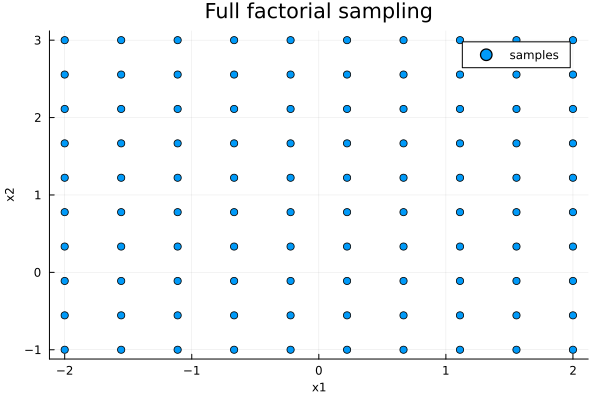

In [3]:
bounds = Matrix{Float64}(undef,2,2)
bounds[1,:] = lb
bounds[2,:] = ub

n_levels = [Int(round(sqrt(n_samples))),Int(round(sqrt(n_samples)))]
full_fact = sampling.gridsamp(bounds,n_levels)
plot(full_fact[:,1], full_fact[:,2], seriestype = :scatter, label = "samples", title = "Full factorial sampling")
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

Latin hypercube sampling relies on random dispersion to span the design space and generally provides good coverage for highdimensional spaces

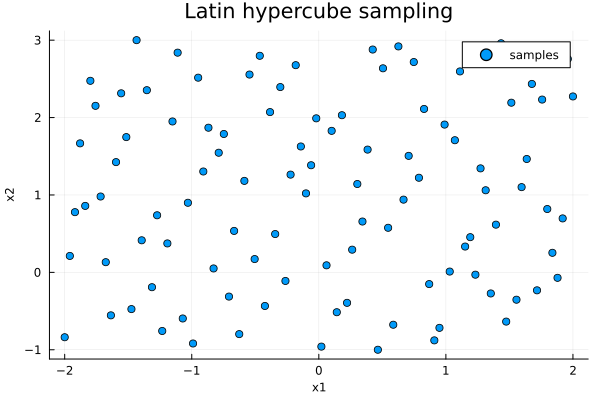

In [4]:
plan, _ = LHCoptim(n_samples,2,100);
lhs = scaleLHC(plan,[(lb[1],ub[1]),(lb[2],ub[2])])
plot(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples", title = "Latin hypercube sampling")
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

# Surrogate modeling

Surrogate models are used in lieu of expensive engineering models to help in model-based design optimization. They are constructed from observations of the actual engineering model $y(\mathbf{x})$ and yield a surrogate $\hat{y}(\mathbf{x})$ that is less expensive to evaluate

## test function: Rosenbrock
Let us consider an example where $y(\mathbf{x})$ is given by the Rosenbrock function

$$
y(\mathbf{x}) = {\left(1 - x_1\right)}^2 + 100{\left(x_2 - x_1^2\right)}^2
$$

We plot it below

In [5]:
# convert 2D matrix rows to Tuples
function toTuple(A::Array{T,2}) where {T<:Any}
    return [tuple(A[c,:]...) for c in 1:size(A,1)]
end

function rosenbrock(x)
    z = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

# grid for plotting
bounds_plot = Matrix{Float64}(undef,2,2)
bounds_plot[1,:] = lb
bounds_plot[2,:] = ub

n_grids = 200
n_plot = [n_grids,n_grids]
X_plot = gridsamp(bounds_plot,n_plot)
x_plot = LinRange(bounds_plot[1,1],bounds_plot[2,1],n_grids)
y_plot = LinRange(bounds_plot[1,2],bounds_plot[2,2],n_grids)

# True function value
y_true = mapslices(rosenbrock,X_plot; dims=[2])

# contour plot
p1 = contour(y_plot, x_plot, vec(y_true), fill = false, levels = 1000, c = :jet1, colorbar_title=L"{y}(\mathbf{x})", colorbar_titlefontsize = 10)
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# Surface plot
p2 = plot(y_plot, x_plot, vec(y_true),st=:surface,camera=(50,40), colorbar_title=L"{y}(\mathbf{x})", legend = :none)
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# combined plot
p_rosenbrock = plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))
# savefig(p_rosenbrock,"rosenbrock.pdf")

## Sampling (training data)

We sample the Rosenbrock function at the Latin hypercube points below

In [6]:
Y = mapslices(rosenbrock,lhs; dims=2); # evaluate LHS samples using Rosenbrock

## Polynomial regression

Polynomial regression assumes that the underlying model $y(x)$ is given by a polynomial function in terms of observations of data $\mathbf{x},\mathbf{y}$. At a given location $\boldsymbol{\zeta}$:

* The model is given by     
$$
\displaystyle \hat{y}(\boldsymbol {\zeta} ) = \mathbf{z}(\boldsymbol {\zeta})^{\mathrm{T}}\mathbf{w},
$$
where $\boldsymbol{\zeta} \in \mathbb{R}^n$ is $n$ dimensional point we want to make predictions at, \
$\mathbf{z}:\mathbb{R}^n \rightarrow \mathbb{R}^{nd+1}$ is the polynomial function of degree $d$,\
and $\mathbf{w} \in \mathbb{R}^{nd+1}$ are its corresponding weights (what we are trying to optimize).\
For example, a polynomial function of degree $d$ looks like\

$$
\mathbf{z}(\mathbf{x}) = \begin{bmatrix} 1 & x_1 & \cdots & x_n & x_1^2 & \cdots & x_n^2 & x_1^d & \cdots & x_n^d \end{bmatrix}^\mathrm{T}
$$

* Consider $p$ training points $\mathbf{x}_1 \cdots \mathbf{x}_p$ and their corresponding function values $\mathbf{y} = \left[y_1,y_2,\cdots,y_p\right]$.
we can write a matrix $\mathbf{Z} \in \mathbb{R}^{p\times{nd+1}}$ as follows
$$
\mathbf{Z}=
\begin{bmatrix}
    1       & x_{11}    & \cdots    & x_{n1}    & x_{11}^2  & \cdots    & x_{n1}^2  & x_{11}^d  & \cdots    & x_{n1}^d  \\
    1       & x_{12}    & \cdots    & x_{n2}    & x_{12}^2  & \cdots    & x_{n2}^2  & x_{12}^d  & \cdots    & x_{n2}^d  \\
    \vdots  & \vdots    & \ddots    & \vdots    & \vdots    & \ddots    & \vdots    & \vdots    & \ddots    & \vdots    \\
    1       & x_{1p}    & \cdots    & x_{np}    & x_{1p}^2  & \cdots    & x_{np}^2  & x_{1p}^d  & \cdots    & x_{np}^d  \\
\end{bmatrix} =
\left[\mathbf{z}(\mathbf{x}_1)~\mathbf{z}(\mathbf{x}_2)~\cdots~\mathbf{z}(\mathbf{x}_p)\right]^{\mathrm{T}}
$$

* We want to find the optimal weights such that
\begin{align*}
    & \underset{\mathbf{w}\in\mathbb{R}^{nd+1}}{\text{minimize}}
    & & ||{\mathbf{Z}\mathbf{w}-\mathbf{y}}||_2^2 + \underbrace{\mathbf{w}^\mathrm{T}{\mathbf{J}}\mathbf{w}}_{\mathrm{regularization~term}}\\		
\end{align*}
The reguralization term is added to avoid an ill-conditioned design matrix ${\mathbf{Z}}^{\mathrm{T}}{\mathbf{Z}}$ when finding the solution by matrix inversion using first-order necessary conditions (FONCs).

${\mathbf{J}}=\mathrm{diag}\left(\left[0~r~\cdots~r\right]^{\mathrm{T}}\right)$, $r$ is the ridge parameter

$$
\left(\mathbf{Z}^{\mathrm{T}}\mathbf{Z} + \mathbf{J}\right)\mathbf{w}^* = \mathbf{Z}^{\mathrm{T}}\mathbf{y}
$$

see the file [surrogate.jl](./surrogate.jl) for an example implementation of RBFs. We train a 2nd degree polynomial regression model below using samples from the Rosenbrock function


In [7]:
# train the model
ls_surrogate = Surrogate(X=lhs, Y=Y, type="LS", lb=lb, ub=ub, r=0.0, d=2)
surrogate_models.train(ls_surrogate.model);

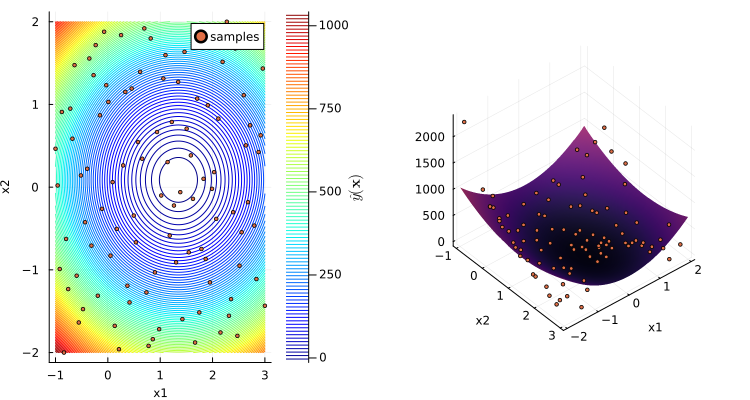

In [8]:
# Predictions
y_hat = surrogate_models.predict(ls_surrogate.model,X_plot)

# contour plot
p1 = contour(y_plot, x_plot, vec(y_hat), fill = false, levels = 100, c = :jet1, colorbar_title=L"\hat{y}(\mathbf{x})", colorbar_titlefontsize = 10)
scatter!(lhs[:,2], lhs[:,1], seriestype = :scatter, label = "samples", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)


# Surface plot
p2 = plot(y_plot, x_plot, vec(y_hat),st=:surface,camera=(50,40), colorbar_title=L"\hat{y}(\mathbf{x})", legend = :none)
scatter3d!(lhs[:,2], lhs[:,1], vec(Y), label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# combined plot
plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))

### A note on the regularization

sometimes an ill-conditioned design matrix $\mathbf{Z}^{\mathrm{T}}\mathbf{Z}$ may result due to the way the data is sampled. We have two data sets shown below. The top row of plots shows a linear regression model through data set 1 [sample_data_1.csv](./sample_data_1.csv). The second row shows a linear regression model trained from data set 2 [sample_data_2.csv](./sample_data_2.csv). Data set 2 has a measurement error in of the data points.

We investigate the effect of the ridge parameter $r$ on the model fit. We increase the ridge parameter from $r=0$ (no regularization) to $r=0.1$. We see that the two models become equivalent after applying some regularization.

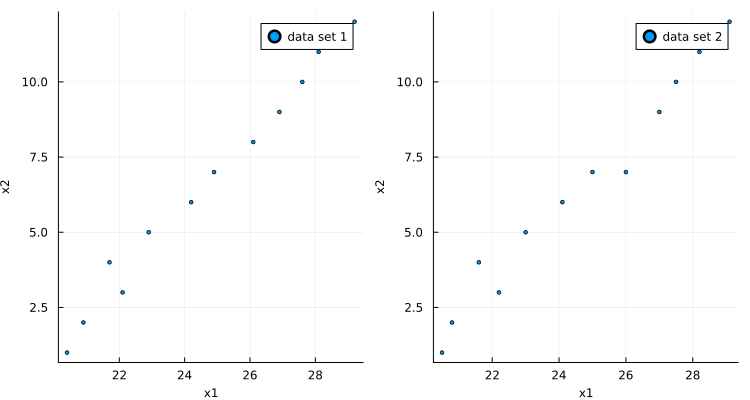

In [9]:
using DelimitedFiles

# read the data sets
data = readdlm("sample_data_1.csv", ',', Float64, skipstart=1)
X_data_1 = data[:,3:4]
Y_data_1 = data[:,2:2]

data = readdlm("sample_data_2.csv", ',', Float64, skipstart=1)
X_data_2 = data[:,3:4]
Y_data_2 = data[:,2:2]

# scatter plot
p1 = scatter(X_data_1[:,2], X_data_1[:,1], seriestype = :scatter, label = "data set 1", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

# scatter plot
p2 = scatter(X_data_2[:,2], X_data_2[:,1], seriestype = :scatter, label = "data set 2", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

# combined plot
plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))


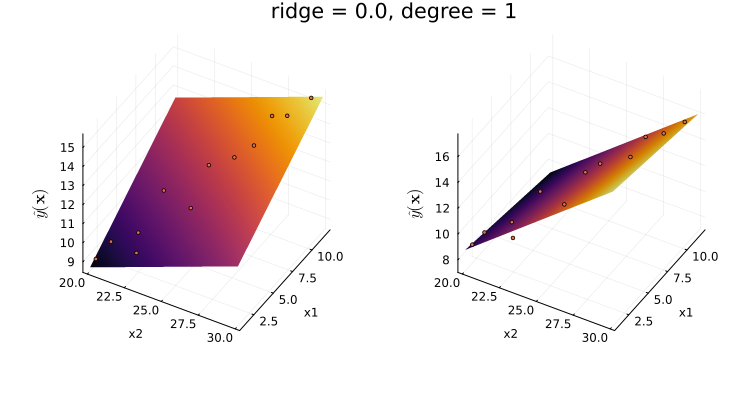

In [10]:
ridge = 0.0
degree = 1
scale = true

# plot bounds
lb_reg = [1.0 20.0]
ub_reg = [12.0 30.0]

bounds_reg = Matrix{Float64}(undef,2,2)
bounds_reg[1,:] = lb_reg
bounds_reg[2,:] = ub_reg

n_grids = 200
n_reg = [n_grids,n_grids]
X_reg = gridsamp(bounds_reg,n_reg)
x_reg = LinRange(bounds_reg[1,1],bounds_reg[2,1],n_grids)
y_reg = LinRange(bounds_reg[1,2],bounds_reg[2,2],n_grids)


# train models
ls1 = Surrogate(X=X_data_1, Y=Y_data_1, type="LS", lb=vec(lb_reg), ub=vec(ub_reg), r=ridge, d=degree, scale=scale)
surrogate_models.train(ls1.model);

ls2 = Surrogate(X=X_data_2, Y=Y_data_2, type="LS", lb=vec(lb_reg), ub=vec(ub_reg), r=ridge, d=degree, scale=scale)
surrogate_models.train(ls2.model);

# Predictions
y_hat_1 = surrogate_models.predict(ls1.model,X_reg)
y_hat_2 = surrogate_models.predict(ls2.model,X_reg)

# Surface plot
p1 = plot(y_reg, x_reg, vec(y_hat_1),st=:surface,camera=(30,40), zlabel=L"\hat{y}(\mathbf{x})", legend = :none)
scatter3d!(X_data_1[:,2], X_data_1[:,1], vec(Y_data_1), label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# Surface plot
p2 = plot(y_reg, x_reg, vec(y_hat_2),st=:surface,camera=(30,40), zlabel=L"\hat{y}(\mathbf{x})", legend = :none)
scatter3d!(X_data_2[:,2], X_data_2[:,1], vec(Y_data_2), label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# combined plot
title = plot(title = "ridge = $ridge, degree = $degree", grid = false, showaxis = false, bottom_margin = -50Plots.px, ticks = false)
p_reg = plot(title, p1, p2, size = (750, 400), layout = @layout([A{0.01h}; [B C]]))
# savefig(p_reg,"ls_reg.pdf")

The condition number of the matrix $A$ is given by $\kappa(A) = \dfrac{\left|\lambda_\mathrm{max}(A)\right|}{\left|\lambda_\mathrm{min}(A)\right|}$, where $\lambda_\mathrm{max}(A)$ and $\lambda_\mathrm{min}(A)$ are the largest and smallest eigenvalues, respectively. The higher the condition number, the more ill-conditioned is the matrix $A$, i.e. the existence of an inverse. Below we check the condition numbers of the design matrix for both regression models.

In [11]:
c1 = cond(ls1.model.B'*ls1.model.B + ls1.model.J)
c2 = cond(ls2.model.B'*ls2.model.B + ls1.model.J)
println("Condition number for model trained from data set 1: $c1", '\n', "Condition number for model trained from data set 2: $c2")

Condition number for model trained from data set 1: 2432.107899123663
Condition number for model trained from data set 2: 1317.1712778994356


## Radial basis function networks

Radial basic function (RBF) neural networks assume the the underlying model $y(x)$ is a result of combined effect of all the training points $\mathbf{x},\mathbf{y}$ at a location $\boldsymbol{\zeta}$. The effect of each training point decays as the distance from said point grows. Distance is given by the $l2$-norm $||\mathbf{x} - \boldsymbol{\zeta}||_2$

* The model is given by 
$$
\displaystyle \hat{y}(\boldsymbol {\zeta} ) = \sum _{i=1}^{p}w_{i}\,b_{i} (\boldsymbol {\zeta}) = \mathbf{b}(\boldsymbol {\zeta})^{\mathrm{T}}\mathbf{w},
$$
where $\boldsymbol{\zeta} \in \mathbb{R}^n$ is the point we want to make predictions at, and $p$ is the number of training points

* $b_{i} : \mathbb{R}^n \rightarrow \mathbb{R}$ is the kernel function and $w_i$ is its corresponding weight (what we are trying to optimize)
$$
b_{i} (\boldsymbol {\zeta}) = \phi (\lambda ||{\boldsymbol {\zeta} -\mathbf {x} _{i}}||_2)
$$
typically the Guassian kernel function $\phi(x) = e^{-x}$

* Consider $p$ training points $\mathbf{x}_1 \cdots \mathbf{x}_p$ and their corresponding function values $\mathbf{y} = \left[y_1,y_2,\cdots,y_p\right]$.
we can write a matrix $\mathbf{B} \in \mathbb{R}^{p\times p}$ in terms of the kernel functions $\mathbf{b} : \mathbb{R}^n \rightarrow \mathbb{R}^p$ as follows
$$
\mathbf{B}=\left[\mathbf{b}(\mathbf{x}_1)~\mathbf{b}(\mathbf{x}_2)~\cdots~\mathbf{b}(\mathbf{x}_p)\right]^{\mathrm{T}}
$$

* We want to find the optimal weights such that
\begin{align*}
    & \underset{\mathbf{w}\in\mathbb{R}^p}{\text{minimize}}
    & & ||{\mathbf{B}\boldsymbol{w}-\mathbf{y}}||_2 + \underbrace{\mathbf{w}^\mathrm{T}{\mathbf{J}}\mathbf{w}}_{\mathrm{regularization~term}}\\		
\end{align*}

using FONCs

$$
\left(\mathbf{B}^{\mathrm{T}}\mathbf{B} + \mathbf{J}\right)\mathbf{w}^* = \mathbf{B}^{\mathrm{T}}\mathbf{y}
$$

see the file [surrogate.jl](./surrogate.jl) for an example implementation of RBFs. We train a radial basis function network model using observations from the Rosenbrock function below


In [12]:
# train the model
rbf_surrogate = Surrogate(X=lhs, Y=Y, type="RBF", lb=lb, ub=ub, r=0.0, λ=0.05, kernel=Guassian)
surrogate_models.train(rbf_surrogate.model);

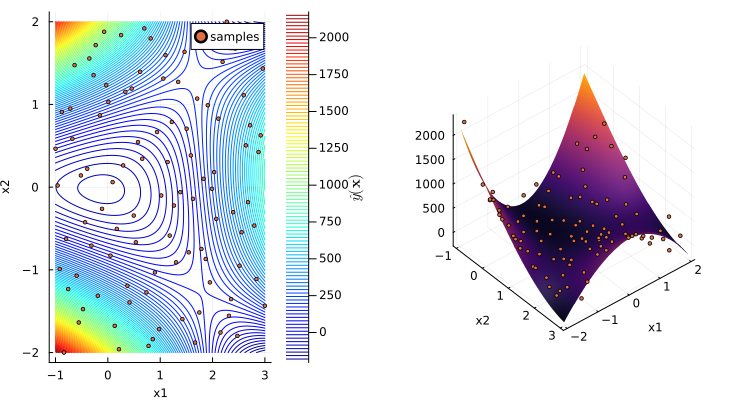

In [13]:
# Predictions
y_hat = surrogate_models.predict(rbf_surrogate.model,X_plot)

# contour plot
p1 = contour(y_plot, x_plot, vec(y_hat), fill = false, levels = 100, c = :jet1, colorbar_title=L"\hat{y}(\mathbf{x})", colorbar_titlefontsize = 10)
scatter!(lhs[:,2], lhs[:,1], seriestype = :scatter, label = "samples", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)


# Surface plot
p2 = plot(y_plot, x_plot, vec(y_hat),st=:surface,camera=(50,40), colorbar_title=L"\hat{y}(\mathbf{x})", legend = :none)
scatter3d!(lhs[:,2], lhs[:,1], vec(Y), label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# combined plot
plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))

### A note on the spread parameter $\lambda$

$\lambda$ must be carefully chosen so that the effect of each training point overlaps with that of nearby points. Otherwise, this results in a poor fit due to the independence of the training points

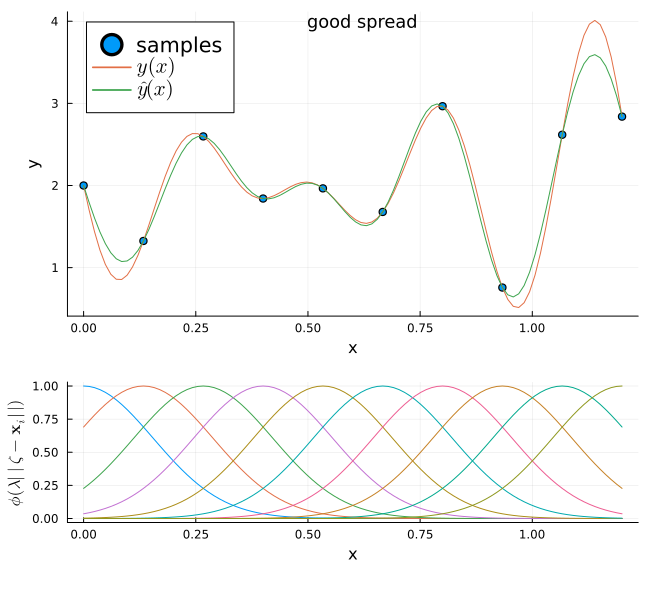

In [14]:
function test_fun_1D(x::Float64)
    -(1.4 - 3.0 * x) * sin(18.0 * x) + 2
end

# plot bounds data
lb_spread = [0.0]
ub_spread = [1.2]
n_samples = 10

bounds_1d = Matrix{Float64}(undef,2,1)
bounds_1d[1,:] = lb_spread
bounds_1d[2,:] = ub_spread
ns = [n_samples]
X_1d = gridsamp(bounds_1d,ns);

# training data
X_1d = collect(X_1d)
Y_1d = test_fun_1D.(X_1d)
    
# test function plot
x_plot_1d = collect(reshape(LinRange(0,1.2,100),100,1))
p1 = plot(X_1d, test_fun_1D, st=:scatter, label="samples" )
plot!(x_plot_1d, test_fun_1D, st=:line, label=L"y(x)",legend=:topleft)
xlabel!("x")
ylabel!("y")

# train the model
rbf1 = Surrogate(X=X_1d , Y=Y_1d, type="RBF", lb=vec(lb_spread), ub=vec(ub_spread), r=0.0, λ=30.0, kernel=Guassian, name="1D RBF good")
train(rbf1.model)

# Predictions
y_plot_1d = surrogate_models.predict(rbf1.model,x_plot_1d)
plot!(x_plot_1d,y_plot_1d, label=L"\hat{y}(x)")
annotate!(0.5, 4.0, text("good spread", :black, :left, 12))

x_plot_1d_scaled = scaling(x_plot_1d,vec(lb_spread),vec(ub_spread),1)
B = basis(rbf1.model.λ,x_plot_1d_scaled,rbf1.model.X,rbf1.model.kernel)'
p2 = plot()
for i = 1:size(B,1)
    plot!(x_plot_1d,B[i,:],label=missing)
    xlabel!("x")
    ylabel!(L"\phi (\lambda \left||{\mathbf{\zeta} -\mathbf{x} _{i}}\right||)")
end
p_rbf_good = plot(p1, p2, size = (650, 600), layout = grid(2, 1, widths=[1.0 ,1.0], heights=[0.65 ,0.3]), legendfontsize = 14)
# savefig(p_rbf_good,"rbf_good.pdf")

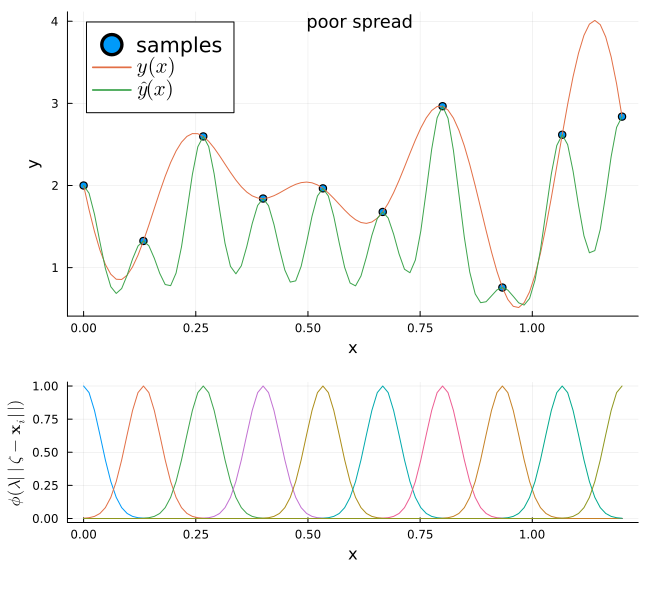

In [15]:
# test function plot
x_plot_1d = collect(reshape(LinRange(0,1.2,100),100,1))
p1 = plot(X_1d, test_fun_1D, st=:scatter, label="samples" )
plot!(x_plot_1d, test_fun_1D, st=:line, label=L"y(x)",legend=:topleft)
xlabel!("x")
ylabel!("y")

# train the model
rbf2 = Surrogate(X=X_1d , Y=Y_1d, type="RBF", lb=vec(lb_spread), ub=vec(ub_spread), r=0.0, λ=500.0, kernel=Guassian, name="1D RBF bad")
train(rbf2.model)

# Predictions
y_plot_1d = surrogate_models.predict(rbf2.model,x_plot_1d)
plot!(x_plot_1d,y_plot_1d, label=L"\hat{y}(x)")
annotate!(0.5, 4.0, text("poor spread", :black, :left, 12))

x_plot_1d_scaled = scaling(x_plot_1d,vec(lb_spread),vec(ub_spread),1)
B = basis(rbf2.model.λ,x_plot_1d_scaled,rbf2.model.X,rbf2.model.kernel)'
p2 = plot()
for i = 1:size(B,1)
    plot!(x_plot_1d,B[i,:],label=missing)
    xlabel!("x")
    ylabel!(L"\phi (\lambda \left||{\mathbf{\zeta} -\mathbf{x} _{i}}\right||)")
end
p_rbf_bad = plot(p1, p2, size = (650, 600), layout = grid(2, 1, widths=[1.0 ,1.0], heights=[0.65 ,0.3]), legendfontsize = 14)
# savefig(p_rbf_bad,"rbf_bad.pdf")

## Kriging surrogate models

We use a popular surrogate modeling known as Kriging (named after the South African geoscientist Krige). Kriging is a geostatistical technique to interpolate the elevation of the landscape as a function of the geographic location at an unobserved location from observations of its value at nearby locations.

* Basic idea assume that the true function is 
$$\hat{y}(x) = f(x) + Z(x)$$
* Where $Z(x)$ is a zero-mean stochastic process that represents the deviation from $f$ ; its covariance is
$$\text{cov}( Z ( x_1 ), Z ( x_2 )) = \sigma^2R( x_1 , x_2 )$$
* R is the spatial correlation function, typically
$$ R( x_1 , x_2 ) = e^{−\theta\left(x_1 − x_2\right)^2} $$
just like the Guassian kernel fucntion in RBF networks
* Use polynomial for $f$ and compute its coefficients using data collected from observations or experiments and correlation function
* we then want to find the polynomial coefficients that minimize the covariance subject to the condition that mean is zero

see [https://www.omicron.dk/dace/dace.pdf](https://www.omicron.dk/dace/dace.pdf) for details of the derivation

In this example, We use Kriging from the [Surrogates.jl](https://surrogates.sciml.ai/stable/) library


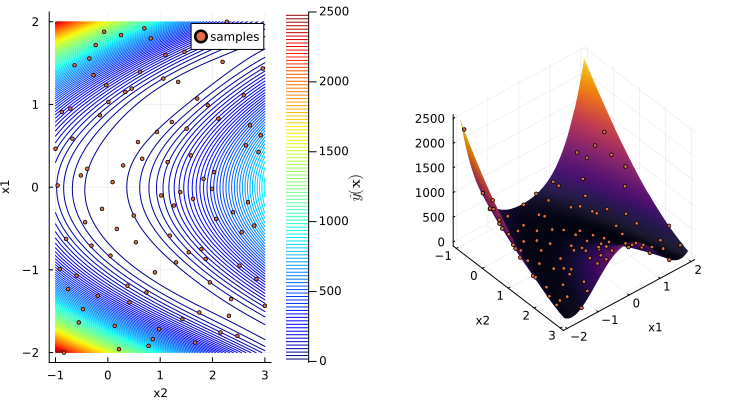

In [16]:
# train the model
kriging_surrogate = Kriging(toTuple(lhs), vec(Y), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.03]);

# Predictions
y_hat = kriging_surrogate.(toTuple(X_plot))

# contour plot
p1 = contour(y_plot, x_plot, vec(y_hat), fill = false, levels = 100, c = :jet1, colorbar_title=L"\hat{y}(\mathbf{x})", colorbar_titlefontsize = 10)
scatter!(lhs[:,2], lhs[:,1], seriestype = :scatter, label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)


# Surface plot
p2 = plot(y_plot, x_plot, vec(y_hat),st=:surface,camera=(50,40), colorbar_title=L"\hat{y}(\mathbf{x})", legend = :none)
scatter3d!(lhs[:,2], lhs[:,1], vec(Y), label = "samples", markersize=2);
xlabel!("x2", xguidefontsize=8)
ylabel!("x1", yguidefontsize=8)

# combined plot
p_kriging = plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))
# savefig(p_kriging,"kriging_example.pdf")

## Cross-validation

There are several metrics to assess the performance of the surrogate model $\hat{y}(\mathbf{x}$

* The “R-square” (coefficient of determination)
$$
R^2 = 1 - \frac{\sum_i\left(y_i-\bar{y}\right)^2}{\sum_i\left(\hat{y}_i-{y}_i\right)^2}
$$
* Mean square error (MSE)
$$
\text{MSE} = \dfrac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_i-{y}_i\right)^2
$$
* Root mean square error (RMSE)
$$
\text{RMSE} = \sqrt{\dfrac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_i-{y}_i\right)^2}
$$

These errors can be computed using various cross-validation strategies:
* Leave-one-out
    * Use $N-1$ points to create metamodel
    * Compute error on left-out point
    * Repeat $N$ times
    * Maximum error found bounds error of metamodel created using N points (under certain conditions)
* k-fold cross-validation
    * Partition the data into $k$ *segments* (folds)
    * Use $k-1$ segments to create metamodel
    * Compute error on the $k$th segment
    * Repeat $k$ times
    * Maximum error found bounds error of metamodel created using $k$-folds (under certain conditions)
    * Average MSE error found using
$$
\text{MSE}_{k\text{-fold}} = \dfrac{1}{k}\sum_{i=1}^{k}\text{MSE}_k
$$

Lets us examine the $k$-fold cross-validation error as we change the parameters of the Kriging model:

Effect of $\theta$:

In [17]:
function KfoldCV(X::AbstractMatrix,Y::AbstractMatrix; n_folds::Int64=5,θ::Float64=0.03)::Float64
    
    rows = collect(Kfold(size(lhs)[1],n_folds))

    MSE = 0
    for fold in rows
        # train the model
        kriging_surrogate = Kriging(toTuple(X[fold,:]), vec(Y[fold]), lb, ub, p=[2.0, 2.0], theta=[θ, θ]);
    
        # Predictions
        test = deleteat!([1:1:size(X)[1];], fold)
        Y_predict = kriging_surrogate.(toTuple(X[test,:]))
    
        # error
        MSE += norm(Y_predict - Y[test])
    end
    
    MSE /= n_folds
end

error_θ = [KfoldCV(lhs,Y,n_folds=5,θ=θ) for θ=1e-2:5e-3:1e-0];

Effect of number of training points $p$ on the Kriging model:

In [18]:
function error_sampling(X::AbstractMatrix,Y::AbstractMatrix; n_samples::Int64)::Float64
    Random.seed!(1234);
    total_samples = size(X,1)
    n = min(total_samples-20,n_samples) # cap n at 160

    # train the model
    kriging_surrogate = Kriging(toTuple(X[1:n,:]), vec(Y[1:n]), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.03]);
    
    # Predictions
    Y_predict = kriging_surrogate.(toTuple(X[total_samples-20:total_samples,:]))
    
    # error
    MSE = norm(Y_predict - Y[total_samples-20:total_samples])
end

error_n = [error_sampling(lhs,Y,n_samples=n) for n=20:2:80];

Plotting $\text{MSE}_{k\text{-fold}}$ versuse $\theta$ and $p$

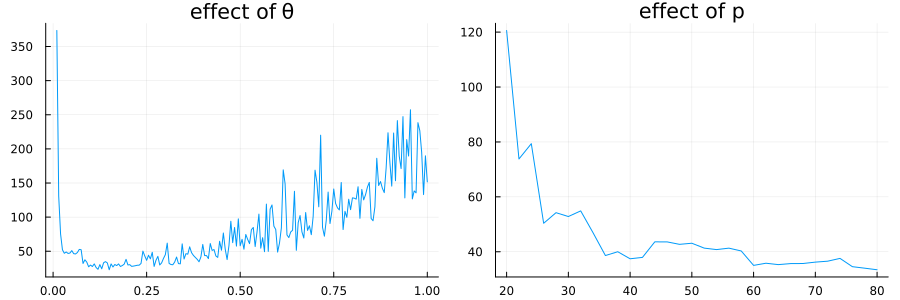

In [19]:
# theta plot
p1 = plot(1e-2:5e-3:1e-0, error_θ, st=:line, title="effect of \\theta" );

# samples plot
p2 = plot(20:2:80, error_n, st=:line, title="effect of p");

# combined plot
plot(p1, p2, size = (900, 300), layout = grid(1, 2, widths=[0.5 ,0.5]), legend=false)